In [122]:
#ライブラリの読み込み
from dpr_models import DPRModel, SimilarityBasedCrossEntropy
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import ast
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import time
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim

In [123]:
class MultimodalDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

        # センサーデータ列（前処理済み：数値＋one-hotカテゴリ）
        self.sensor_columns = [
            "heart_rate(bpm)", "latitude", "longitude", "stop"
        ] + [col for col in df.columns if col.startswith(("location_", "place_", "city_", "movement_"))] + ["triangle_time_sin", "triangle_time_cos"]



    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # センサーデータ（数値＋one-hotカテゴリ）
        sensor_input = torch.tensor([float(row[col]) for col in self.sensor_columns], dtype=torch.float32)

        # 画像読み込み
        image_id = row["ImageID"]
        month = image_id[:6]
        day = image_id[6:8]
        img_path = os.path.join(self.image_dir, month, day, image_id)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)


        return image, sensor_input


In [124]:
#画像前処理
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [125]:
import pandas as pd

# CSV読み込み（カラム数に応じて dtype警告を回避するため low_memory=False 推奨）
data = pd.read_csv("/home/mizuguchi/workspace/time_estimate/2020年4月/lifelog_labeled.csv")

#異常データ点判定列を作成
#対象列リスト（必要な異常項目のみ）
cols = [
    "anomaly_hr_thresh", "anomaly_hr_time", "anomaly_hr_diff", "anomaly_hr_zscore",
    "anomaly_img_human","anomaly_img_dark", "anomaly_img_shift","anomaly_img_block", "anomaly_img_broken"
]

# lifelogに実際に存在する列だけを抽出
use_cols = [c for c in cols if c in data.columns]

# 数値変換＋欠損処理＋1以上でTrue
data["is_anomaly"] = (
    data[use_cols]
    .apply(pd.to_numeric, errors="coerce")  # "1", True なども吸収
    .fillna(0)
    .astype(int)
    .any(axis=1)
)
# 確認
print("is_anomaly = True の件数:", data["is_anomaly"].sum())
from torch.utils.data import DataLoader

# 時系列順に並べる（例：訓練＝前半75%、テスト＝後半25%）
n_total = len(data)
n_train = int(n_total * 0.75)

train_data = data.iloc[:n_train]
test_data  = data.iloc[n_train:]

# データセットを作成（あなたのMultimodalDatasetに合わせる）
train_dataset = MultimodalDataset(
    train_data,
    image_dir="/home/mizuguchi/workspace/transfer2-main/DMR/Lifelog-6/images",
    transform=image_transform
)
test_dataset = MultimodalDataset(
    test_data,
    image_dir="/home/mizuguchi/workspace/transfer2-main/DMR/Lifelog-6/images",
    transform=image_transform
)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=512, shuffle=False)

print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")

is_anomaly = True の件数: 350
Train size: 6051, Test size: 2018


/tmp/ipykernel_31875/2525115818.py:4: DtypeWarning: Columns (16,31) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/home/mizuguchi/workspace/time_estimate/2020年4月/lifelog_labeled.csv")


In [127]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [128]:
sensor_columns = [
    "heart_rate(bpm)", "latitude", "longitude", "stop"
] + [col for col in data.columns if col.startswith(("location_", "place_", "city_", "movement_"))] \
  + ["triangle_time_sin", "triangle_time_cos"]


# 平均・標準偏差のテンソルを作成
sensor_mean = torch.tensor(data[sensor_columns].mean().values, dtype=torch.float32).to(device)
sensor_std  = torch.tensor(data[sensor_columns].std().values, dtype=torch.float32).to(device)

# input_dim も合わせて取得
input_dim = len(sensor_columns)

print("センサ特徴量の平均:", sensor_mean)
print("センサ特徴量の標準偏差:", sensor_std)
print("次元数:", input_dim)

センサ特徴量の平均: tensor([ 8.8689e+01,  5.3398e+01, -6.2182e+00,  8.5240e-01,  8.4592e-01,
         1.2393e-04,  1.2393e-04,  1.2393e-04,  2.4786e-04,  2.4786e-04,
         9.9145e-04,  2.4786e-04,  2.4786e-04,  2.4786e-04,  2.4786e-04,
         2.4786e-04,  8.6752e-04,  2.4786e-04,  2.4786e-04,  2.4786e-04,
         2.4786e-04,  2.4786e-04,  2.4786e-04,  1.2393e-04,  2.4786e-04,
         1.2393e-04,  3.7179e-04,  2.4786e-04,  2.4786e-04,  2.4786e-04,
         2.4786e-04,  2.4786e-04,  2.4786e-04,  2.4786e-04,  2.3547e-03,
         7.4359e-04,  2.4786e-04,  2.4786e-04,  2.4786e-04,  2.4786e-04,
         2.4786e-04,  2.4786e-04,  2.4786e-04,  2.4786e-04,  2.4786e-04,
         2.4786e-04,  2.4786e-04,  2.4786e-04,  2.4786e-04,  2.4786e-04,
         2.4786e-04,  4.9572e-04,  1.2393e-04,  4.9572e-04,  2.4786e-04,
         2.4786e-04,  2.4786e-04,  2.4786e-04,  4.9572e-04,  2.4786e-04,
         2.4786e-04,  2.4786e-04,  2.4786e-04,  2.4786e-04,  2.4786e-04,
         1.2393e-04,  2.4786e-04,  2.478

In [129]:
from dpr_models import ImageEncoder, SensorEncoder, DPRModel, SimilarityBasedCrossEntropy

image_encoder = ImageEncoder(output_dim=128)
sensor_encoder = SensorEncoder(
    avg=sensor_mean,
    std=sensor_std,
    input_dim=input_dim,
    hidden_dim=128,
    output_dim=128,
    normalization=True
)

model = DPRModel(image_encoder, sensor_encoder).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4) 
criterion = SimilarityBasedCrossEntropy(temperature=0.5, device=device)


In [130]:
import time

EPOCHS = 50
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    start = time.time()

    for images, sensors in train_loader:
        images = images.to(device)
        sensors = sensors.to(device)

        image_emb, sensor_emb = model(images, sensors)
        loss = criterion(image_emb, sensor_emb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    elapsed = time.time() - start
    print(f"[Epoch {epoch+1}] Loss: {total_loss:.4f} | Time: {elapsed:.2f} sec")


[Epoch 1] Loss: 73.5959 | Time: 8.34 sec
[Epoch 2] Loss: 72.1572 | Time: 8.26 sec
[Epoch 3] Loss: 70.9662 | Time: 8.29 sec
[Epoch 4] Loss: 69.7722 | Time: 8.33 sec
[Epoch 5] Loss: 68.6048 | Time: 8.31 sec
[Epoch 6] Loss: 67.3892 | Time: 8.31 sec
[Epoch 7] Loss: 66.1787 | Time: 8.32 sec
[Epoch 8] Loss: 65.0274 | Time: 8.29 sec
[Epoch 9] Loss: 64.0719 | Time: 8.27 sec
[Epoch 10] Loss: 63.4093 | Time: 8.36 sec
[Epoch 11] Loss: 62.9696 | Time: 8.31 sec
[Epoch 12] Loss: 62.6573 | Time: 8.30 sec
[Epoch 13] Loss: 62.4202 | Time: 8.32 sec
[Epoch 14] Loss: 62.2278 | Time: 8.31 sec
[Epoch 15] Loss: 62.0572 | Time: 8.28 sec
[Epoch 16] Loss: 61.8842 | Time: 8.32 sec
[Epoch 17] Loss: 61.7451 | Time: 8.29 sec
[Epoch 18] Loss: 61.6273 | Time: 8.21 sec
[Epoch 19] Loss: 61.5045 | Time: 8.29 sec
[Epoch 20] Loss: 61.3908 | Time: 8.31 sec
[Epoch 21] Loss: 61.2791 | Time: 8.36 sec
[Epoch 22] Loss: 61.2034 | Time: 8.32 sec
[Epoch 23] Loss: 61.1134 | Time: 8.29 sec
[Epoch 24] Loss: 61.0130 | Time: 8.31 sec
[

In [133]:
import torch
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

model.eval()

similarities = []
labels = []

# DataFrameから is_anomaly 列を取得
df_test = test_loader.dataset.df.reset_index(drop=True)

with torch.no_grad():
    for batch_idx, (images, sensors) in enumerate(test_loader):
        images = images.to(device)
        sensors = sensors.to(device)

        image_emb, sensor_emb = model(images, sensors)
        sims = F.cosine_similarity(sensor_emb, image_emb, dim=1).cpu().numpy()

        similarities.extend(sims)

        # バッチ範囲に対応する is_anomaly を df_test から取得
        start_idx = batch_idx * test_loader.batch_size
        print(start_idx)
        end_idx = start_idx + len(images)
        print(end_idx)
        batch_labels = df_test.iloc[start_idx:end_idx]["is_anomaly"].astype(bool).tolist()
        labels.extend(batch_labels)

# データフレーム化
df_sim = pd.DataFrame({
    "similarity": similarities,
    "is_anomaly": labels
})


0
512
512
1024
1024
1536
1536
2018


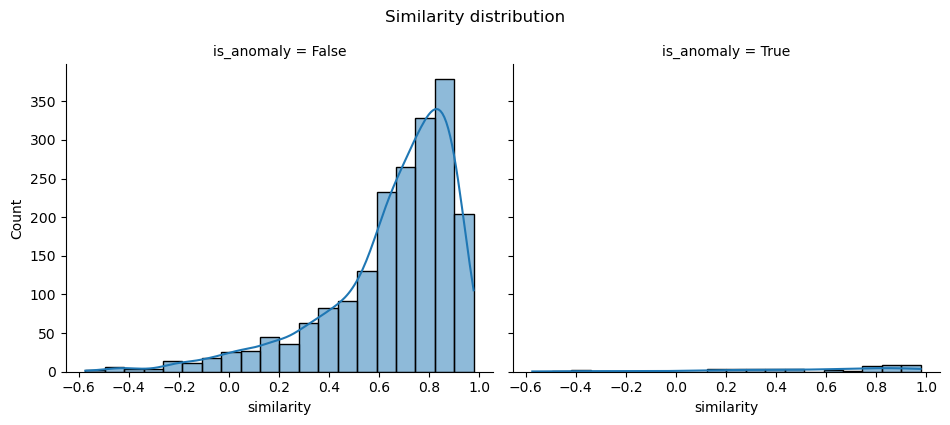

In [137]:
sns.displot(
    data=df_sim,
    x="similarity",
    col="is_anomaly",
    kind="hist",
    kde=True,
    fill=True,
    bins=20,
    height=4,
    aspect=1.2
)

plt.suptitle("Similarity distribution", y=1.05)
plt.show()